In [135]:
import json 
import numpy as np
import math
import sys
import random 
class Field:
    def __init__(self, field):
        self.field = figures
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]
        
    def __init(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
        self.w_width = self.field['main_rectangle'][0][0]
        self.w_length = self.field['main_rectangle'][0][1]

In [141]:
class Robot(Field):
    def __init__(self, x = 1, y = 0.5, yaw = 0):
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.yaw = yaw  # robot's orientation 
        self.forward_noise = 0.05   # noise of the forward movement
        self.turn_noise = 0.1      # noise of the turn
        self.sense_noise = 1   # noise of the sensing
        
        
    def set_coord(self, new_x, new_y, new_orientation):
        #if new_orientation < 0 or new_orientation >= 2 * pi:
        #   raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.yaw = float(new_orientation)
        
    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
        self.forward_noise = float(new_forward_noise)
        self.turn_noise = float(new_turn_noise)
        self.sense_noise = float(new_sense_noise)  
    
    def sense(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 
                             + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        return z
    
    
    def move(self, x, y, yaw):
        # turn, and add randomness to the turning command
        orientation = self.yaw + float(yaw) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi

        # move, and add randomness to the motion command
        x = self.x + x + random.gauss(0, self.forward_noise)
        y = self.y + y + random.gauss(0, self.forward_noise)
        
        #x = math.copysign(Field.w_width, x) if math.fabs(x) >= Field.w_width
        if math.fabs(x) >= field.w_width:
            x = math.copysign(field.w_width/2.0, x)
        if math.fabs(y) >= field.w_length:
            y = math.copysign(field.w_length/2.0, y)
            
        # set particle
        self.x = x
        self.y = y
        self.yaw = orientation
    
    def gaussian(self, x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-(x ** 2) / 2*(sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
    def observation_score(self, observations, landmarks): #particle weight calculation
        prob = 1.0
        for color_landmarks in landmarks:
            for landmark in landmarks[color_landmarks]:
                dists = []
                if len(observations[color_landmarks]) != 0:
                    for observation in observations[color_landmarks]:
                #calc posts coords in field for every mesurement
                        x_posts = self.x + observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw)
                        y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                    prob *= self.gaussian(min(dists), self.sense_noise)
        return prob
    
    def observation_to_predict(self, observations, landmarks):
        predicts = []
        for color_landmarks in landmarks:
            for landmark in landmarks[color_landmarks]:
                x_posts = self.x + observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw)
                y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                predicts.append([x_posts, y_posts])
        return predicts
    
    def update_coord(self, particles):
        x = 0.0
        y = 0.0 
        orientation = 0.0
        for particle in particles:
            x += particle[0].x * particle[1]
            y += particle[0].y * particle[1]
            orientation += particle[0].yaw * particle[1]
        self.x = x
        self.y = y
        self.yaw = orientation
    
    def return_coord(self):
        return self.x, self.y, self.orientation

In [142]:
class ParticleFilter():
    def __init__(self, myrobot, field, landmarks,
                 n = 200, forward_noise = 0.025, 
                 turn_noise = 0.1, sense_noise = 0.1, gauss_noise = 0.4, 
                 consistency = 0.0, dist_threshold = 0.5, goodObsGain = 0.1,
                 badObsCost = 0.1, stepCost = 0.1 ):
        self.forward_noise = forward_noise
        self.turn_noise = turn_noise
        self.sense_noise = sense_noise
        self.gauss_noise = gauss_noise
        self.logs = open('logs/logs.txt','w')
        self.n = n  # number of particles
        self.count = 0
        self.myrobot = myrobot
        self.p = [] 
        self.yaw_noise = 0.05
        self.gen_particles() 
        self.landmarks = landmarks
        sys.stdout = self.logs
        self.consistency = consistency
        self.goodObsGain = goodObsGain
        self.badObsCost = badObsCost
        self.stepCost = stepCost
        self.dist_threshold = dist_threshold
    
    def update_consistency(self, obseravations):
        #prob = self.myrobot.observation_score(observations)
        stepConsistency = 0
        for color_landmarks in self.landmarks:
            for landmark in self.landmarks[color_landmarks]:
                dists = []
                if len(observations[color_landmarks]) != 0:
                    for observation in observations[color_landmarks]:
                #calc posts coords in field for every mesurement
                        x_posts = (self.myrobot.x + observation[0]*math.sin(-self.myrobot.yaw) 
                                   + observation[1]*math.cos(-self.myrobot.yaw))
                        y_posts = (self.myrobot.y + observation[0]*math.cos(-self.myrobot.yaw) 
                                   - observation[1]*math.sin(-self.myrobot.yaw))
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                    if min(dists) < self.dist_threshold:
                        stepConsistency += self.goodObsGain
                    else:
                        stepConsistency -= self.badObsCost
                else:
                    stepConsistency -= self.stepCost
        print(stepConsistency)
        self.consistency += stepConsistency
    
    def uniform_reset(self):
        self.p=[]
        for i in range(self.n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            self.p.append([x,0])
        self.myrobot.update_coord(self.p)
            
    def gen_particles(self):
        print('initial,step ', self.count, file=self.logs)
        print('$$', file=self.logs)
        print("position ", self.myrobot.x, ' ', 
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        self.p = []
        for i in range(self.n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise)
            yaw = self.myrobot.yaw + random.gauss(0, self.yaw_noise)*math.pi
            yaw %= 2 * math.pi
            self.p.append([Robot(x_coord, y_coord, yaw), 0])
            print(x_coord, ' ', y_coord, ' ', yaw, file=self.logs)
        #print('|', file = self.logs)
        self.count += 1
            
    def move(self, x, y, yaw):
        self.myrobot.move(x, y, yaw)
        print('|moving,step ', self.count, file=self.logs)
        print('$$', file=self.logs)
        print("position ", self.myrobot.x, ' ', 
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        # now we simulate a robot motion for each of
        # these particles
        for partic in self.p:
            partic[0].move(x, y, yaw)
            print(partic[0].x, ' ', 
              partic[0].y, ' ', partic[0].yaw, file=self.logs) 
        #print('|', file = self.logs)  
        self.count += 1
            
            
    def do_n_steps(self, n_steps):
        for i in range(n_steps):
            self.step()
            
    def gen_n_particles_robot(self, n):
        p = []
        for i in range(n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise*3)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise*3)
            yaw = self.myrobot.yaw + random.gauss(0, self.yaw_noise*3)*math.pi
            yaw %= 2 * math.pi
            p.append([Robot(x_coord, y_coord, yaw), 0])
        return p
    
    def gen_n_particles(self, n):
        tmp = []
        for i in range(n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            tmp.append([x,0])
        return tmp
    
    def observation_to_predict(self, observations):
        predicts = []
        for color_landmarks in self.landmarks:
            for obs in observations[color_landmarks]:
                x_posts = self.myrobot.x + obs[0]*math.sin(-self.myrobot.yaw) + obs[1]*math.cos(-self.myrobot.yaw)
                y_posts = self.myrobot.y + obs[0]*math.cos(-self.myrobot.yaw) - obs[1]*math.sin(-self.myrobot.yaw)
                predicts.append([x_posts, y_posts])
        return predicts 
    
    def resampling(self, observations):
        print('|resempling,step ', self.count, file=self.logs)
        print('$', self.observation_to_predict(observations), '$', file=self.logs)
        p_tmp = []
        w = []
        S = 0
        for i in range(self.n):
            w.append(self.p[i][0].observation_score(observations, self.landmarks))
            S += (w[i])
        for i in range(self.n):
            w[i] = w[i]/S
            #S += w[i]
        index = int(random.random() * self.n)
        beta = 0.0
        mw = max(w)
        #print(mw)
        new_particles = {}
        for i in range(self.n):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.n
            if index in new_particles.keys():
                new_particles[index] += 1
            else:
                new_particles[index] = 1
            #p_tmp.append([self.p[index][0],w[index]])
        #print(p_tmp)
        for el in new_particles:
            p_tmp.append([self.p[el][0],w[el]*new_particles[el]])
        S = 0
        for i in range(len(p_tmp)):
            S += p_tmp[i][1]
        for i in range(len(p_tmp)):
            p_tmp[i][1] /= S
        self.myrobot.update_coord(p_tmp)
        self.update_consistency(observations)
        print("position ", self.myrobot.x, ' ', 
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        new_particles = self.gen_n_particles_robot(self.n - len(p_tmp))
        p_tmp.extend(new_particles)
        self.p = p_tmp
        for particle in p_tmp:
            print(particle[0].x, ' ', 
              particle[0].y, ' ', particle[0].yaw, file=self.logs) 
        #print('|', file = self.logs)
        self.count += 1
        self.update_consistency(observations)
        
    def custom_reset(self, x, y, yaw):
        self.myrobot.x = x
        self.myrobot.y = y
        self.myrobot.yaw = yaw
        self.p = gen_n_particles_robot(self.n)
        
    def fall_reset(self, observations):
        self.update_consistency(observations)
        self.custom_reset(self.myrobot.x + random.gauss(0, self.sense_noise),
                         self.myrobot.y + random.gauss(0, self.sense_noise),
                         self.myrobot.y  + random.gauss(0, self.sense_noise))
        self.resampling(observations)
        

In [137]:
figures = {
    "main_rectangle": [
        [2.6, 3.6]
    ]
}

In [136]:
figures = {
    "circles": [
    [3, 4.5, 1]
    ], 
    "lines": [
     [[0, 9], [4.5, 4.5]] 
    ], 
    "points": [
        [0, 0]
    ], 
    "main_rectangle": [
        [2.6, 3.6]
    ], 
    "rectangles": [
        [[2, 0], 2, 1],[[2,8],2,1]
    ]
}

In [138]:
path = "untitled.json"
figures = {
    "main_rectangle": [
        [2.6, 3.6]
    ]
}
field = Field(path)

In [140]:
field.w_width

2.6

In [356]:
observations = {"blue_posts": [[-1,4.5],[1,4.5]], 
              "yellow_posts":[[-1,-4.5],[1,-4.5]]}

In [357]:
landmarks = {"blue_posts": [
    [-1.0, 4.5], [1.0, 4.5]
    ],
    "yellow_posts":[
    [-1.0, -4.5], [1.0, -4.5]
    ]
}

In [358]:
observations2 = {"blue_posts": [[-2,3.5],[2,3.5]], 
              "yellow_posts":[[-2,-5.5],[2,-5.5]]}

In [365]:
import matplotlib.pylab as plt
def visualization(robot, step, pr, factor = 7 ):
    
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title('Particle filter, step ' + str(step))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    for el in field.field:
        if el == 'circles':
            for circle in field.field['circles']:
                plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
                plt.gca().add_patch(plot_circle)
        if el == 'lines' :     
            for line in field.field['lines']:
                plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                plt.gca().add_line(plot_line)
        if el == 'rectangles' :     
            for rectangle in field.field['rectangles']:
                rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
                plt.gca().add_patch(rect)
    '''
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].yaw)/factor, 2*math.sin(p[ind][0].yaw)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
    '''
    # draw resampled particles
    for ind in range(len(pr)):
 
        # particle
        circle = plt.Circle((pr[ind][0].x, pr[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(pr[ind][0].x, pr[ind][0].y, 2*math.cos(pr[ind][0].yaw)/factor, math.sin(pr[ind][0].yaw)/factor,width=1/factor, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((robot.x, robot.y), 1./factor/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(robot.x, robot.y, math.cos(robot.yaw)/factor, math.sin(robot.yaw)/factor, width=1/factor, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks:
        for lms in landmarks[lm]:
            circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor/2, facecolor = '#060C73', edgecolor='#060C73')
            plt.gca().add_patch(circle)
    
 
    plt.savefig("figure_" + str(step) + ".png")
    #plt.close()

In [359]:
robot = Robot()
robot.set_coord(0, 0, math.pi/2)
               

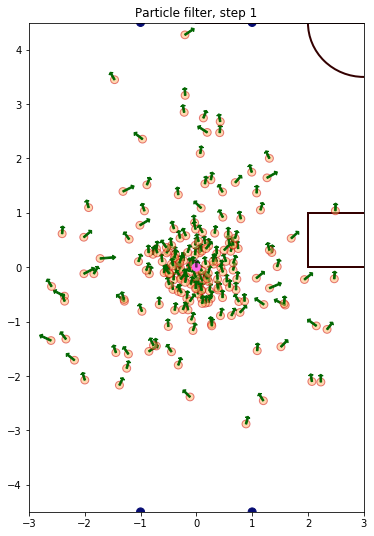

In [360]:
visualization(robot, 1,  pf.p, factor = 7)


In [361]:
pf = ParticleFilter(robot, field, landmarks, sense_noise = 0.5, n = 200)

In [362]:
p = pf.p
observations = {"blue_posts": [[-1,4.5],[1,4.5]], 
              "yellow_posts":[[-1,-4.5],[1,-4.5]]}

In [363]:
#pf.custom_reset()
pf.resampling(observations)
#visualization(robot, 1, [], pf.p, factor = 7)
#m = max(pf.p, key=lambda tup: tup[1])[0]
#score = max(pf.p, key=lambda tup: tup[1])[1]
#print(m.x,m.y,m.orientation)

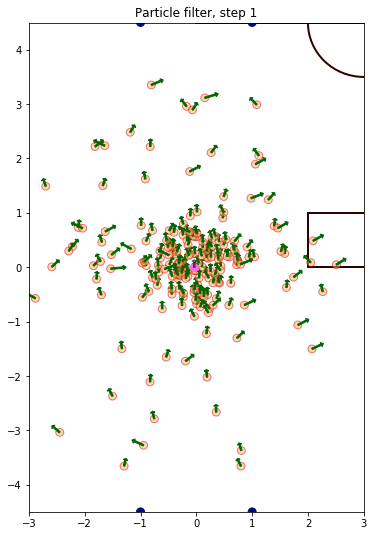

In [368]:
visualization(robot, 1,  pf.p, factor = 7)

In [575]:
observations = {"blue_posts": [], 
              "yellow_posts":[]}
pf.resampling(observations)

In [576]:
pf.consistency


0.0

In [369]:
a, b, c = input()

 110


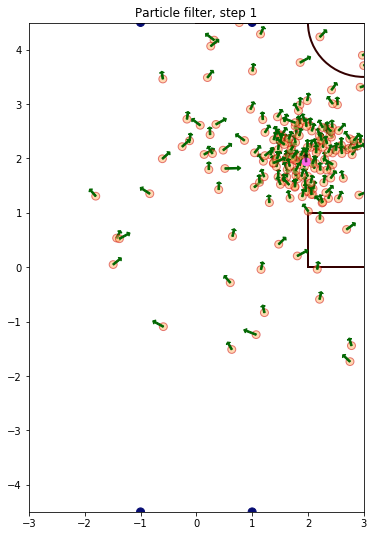

In [371]:

pf.move(float(a),float(b),float(c))
visualization(robot, 1,  pf.p, factor = 7)

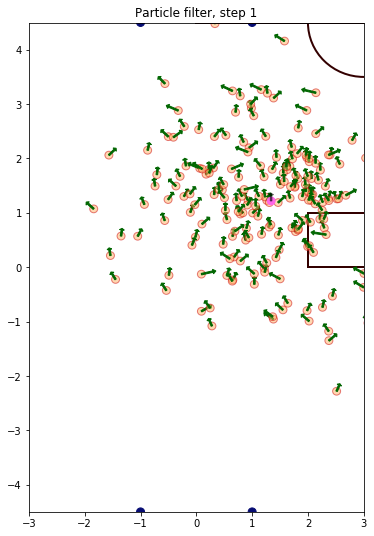

In [377]:
pf.resampling(observations2)
visualization(robot, 1,  pf.p, factor = 7)

In [ ]:
measurment_[0]*math.sin(-orientation) + measurment_[1]*math.cos(-orientation)

In [691]:
for i in range(len(landmarks)):
        for measurment_ in measurement:
            dist = math.sqrt((x + measurment_[0]*math.sin(-orientation) 
                              + measurment_[1]*math.cos(-orientation) - landmarks[i][0]) ** 2 + (y + measurment_[0]*math.cos(-orientation) 
                                  - measurment_[1]*math.sin(-orientation) - landmarks[i][1])** 2 )
                dists.append(dist)
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            #prob *= self.gaussian(dist, self.sense_noise, math.sqrt(measurement[i][0]**2+measurement[i][1]**2)) 
            prob *= gaussian(min(dists), 0.4) 
            print(min(dists))
def gaussian(x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return math.exp(-(x ** 2) / (sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))

In [117]:
logs = open('logs/logs4555.0.txt','r')


In [118]:
log = logs.read()

In [119]:
logi = log.split('|')

In [120]:
b = " []"
vis_logs = []
for lg in logi[0::2]:
    particles = logi[logi.index(lg) + 1].split("\n")
    pr = []
    particles.pop()
    particles.pop(0)
    if lg.split("\n")[0].split(',')[0] == "resempling":
        pr = logi[logi.index(lg)].split("\n")[1].split("$")[1]
        for char in b:
            pr = pr.replace(char,"")
        pr = pr.split(",")
        pr = [[float(px),float(py)] for px, py in zip(pr[0::2], pr[1::2])]
    vis_logs.append([lg.split("\n")[0].split(',')[0], 
                     [float(lg.split("\n")[2].split()[1]),
                    float(lg.split("\n")[2].split()[2]),float(lg.split("\n")[2].split()[3])],
         
                    [[float(s.split()[0]),float(s.split()[1]),float(s.split()[2])] for s in particles],
                     pr])

<Figure size 432x288 with 0 Axes>

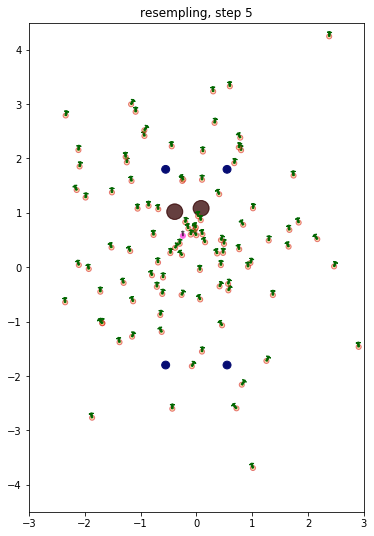

In [125]:
visualization_logs(vis_logs, vis_logs
                   [5], factor1 = 11, factor2 = 7)

In [67]:
vis_logs[152]

['resempling',
 [-0.2726271, 0.6491655, 1.837398],
 [[1.487942, -1.494843, 1.854193],
  [-1.252212, -2.24438, 1.973077],
  [-3.049994, 0.1933622, 1.853269],
  [1.564635, 0.07636323, 1.96021],
  [-1.307366, 2.035263, 1.799695],
  [0.5318687, 1.648661, 1.696272],
  [1.914345, 1.757836, 1.775691],
  [0.4151668, 0.23724, 1.790155],
  [1.482981, -1.830142, 1.768981],
  [-0.6227747, -0.438213, 1.875229],
  [-2.567933, -1.152483, 1.854448],
  [-0.7466334, -2.105208, 1.856246],
  [-0.6137198, -0.1273074, 1.770705],
  [-2.537808, 3.537637, 1.947625],
  [-1.528664, 1.168362, 1.780323],
  [-0.2065064, 0.3961089, 1.877043],
  [-1.300537, 1.254041, 1.591176],
  [-0.08161217, 2.919917, 1.775752],
  [0.2194026, -0.07785374, 1.712175],
  [0.04149285, 1.017207, 1.872399],
  [0.1150417, 0.6999536, 1.830829],
  [1.309053, 0.1329637, 1.879403],
  [-1.091516, 0.2189171, 1.786104],
  [-0.3503857, -0.362518, 2.058913],
  [0.5443874, 0.5169906, 1.926972],
  [0.8958304, -0.8175267, 1.625014],
  [-2.489968, -0.

In [202]:
field_small = Field()

TypeError: __init__() missing 1 required positional argument: 'field'

In [8]:
import matplotlib.pylab as plt
import time

def visualization_logs(logs, log, factor1 = 7, factor2 = 7):
    plt.clf()
    plt.figure("Robot in the world",figsize=(field.w_width, field.w_length))
    plt.title(log[0] + ', step ' + str(logs.index(log)))
 
    # draw coordinate grid for plotting
    grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_length/2.0, field.w_length/2.0]
    ax = plt.axis(grid)
    
    #for el in field.field:
        #if el == 'circles':
            #for circle in field.field['circles']:
              #  plot_circle = plt.Circle((circle[0], circle[1]), circle[2],linewidth=2, fill=False, edgecolor='#330000')
               # plt.gca().add_patch(plot_circle)
        #if el == 'lines' :     
            #for line in field.field['lines']:
               # plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle="-", color='#330000')
                #plt.gca().add_line(plot_line)
        #if el == 'rectangles' :     
            #for rectangle in field.field['rectangles']:
              #  rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle="-", fill = False, edgecolor='#330000')
              #  plt.gca().add_patch(rect)
    '''
    # draw particles
    for ind in range(len(p)):
 
        # particle
        circle = plt.Circle((p[ind][0].x, p[ind][0].y), 1./factor/2, facecolor='#ffb266', edgecolor='#994c00', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(p[ind][0].x, p[ind][0].y, 2*math.cos(p[ind][0].yaw)/factor, 2*math.sin(p[ind][0].yaw)/factor, width=1/factor, alpha=1., facecolor='#994c00', edgecolor='#994c00')
        plt.gca().add_patch(arrow)
    '''
    # draw predicted landmarks
    if log[0] == "resempling":
        for lg in log[3]:
            circle = plt.Circle((lg[0], lg[1]), 1./factor2, facecolor='#330000', edgecolor='#330000', alpha=0.5)
            plt.gca().add_patch(circle)
          
          
    
    # draw resampled particles
    for lg in log[2]:
 
        # particle
        circle = plt.Circle((lg[0], lg[1]), 1./factor1/2, facecolor='#ffb266', edgecolor='#cc0000', alpha=0.5)
        plt.gca().add_patch(circle)
 
        # particle's orientation
        arrow = plt.Arrow(lg[0], lg[1], 2*math.cos(lg[2])/factor1, math.sin(lg[2])/factor1,width=1/factor2, alpha=1., facecolor='#006600', edgecolor='#006600')
        plt.gca().add_patch(arrow)
 

    # robot's location
    circle = plt.Circle((log[1][0], log[1][1]), 1./factor1/2, facecolor='#FF66E9', edgecolor='#FF66E9')
    plt.gca().add_patch(circle)
 
    # robot's orientation
    arrow = plt.Arrow(log[1][0], log[1][1], math.cos(log[1][2])/factor1, math.sin(log[1][2])/factor1, width=1/factor1, alpha=0.5, facecolor='#000000', edgecolor='#000000')
    plt.gca().add_patch(arrow)


    #fixed landmarks of known locations2
   
    for lm in landmarks_small:
        for lms in landmarks_small[lm]:
            circle = plt.Circle(((lms[0], lms[1])), 
                                1./factor2/2, facecolor = '#060C73', edgecolor='#060C73')
            plt.gca().add_patch(circle)
    
 
    #plt.savefig("figure_" + str(logs.index(log)) + ".png")

   
    #plt.close()

In [320]:
for i in range(len(landmarks)):
        for measurment_ in measurement:
            dist = math.sqrt((x + measurment_[0]*math.sin(-orientation) 
                              + measurment_[1]*math.cos(-orientation) - landmarks[i][0]) ** 2 + (y + measurment_[0]*math.cos(-orientation) 
                                  - measurment_[1]*math.sin(-orientation) - landmarks[i][1])** 2 )
                dists.append(dist)
            #print(self.gaussian(dist, self.sense_noise, measurement[i]))
            #prob *= self.gaussian(dist, self.sense_noise, math.sqrt(measurement[i][0]**2+measurement[i][1]**2)) 
            prob *= gaussian(min(dists), 0.4) 
            print(min(dists))
def gaussian(x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return math.exp(-(x ** 2) / (sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))

IndentationError: unexpected indent (<ipython-input-320-ba2eed163076>, line 6)

In [426]:
-0.45*math.sin(-1.57)+ 0.8*math.cos(1.57) 

0.45063691868791217

In [419]:
-0.45*math.cos(-1.57)  - 0.8*math.sin(-1.57)

0.7996413993256378

In [16]:
landmarks_small = {
    "blue_posts": [
    [-0.55, 1.8], [0.55, 1.8]
    ],
    "yellow_posts":[
    [-0.55, -1.8], [0.55, -1.8]
    ]
}

In [17]:
with open("landmarks.json", "r") as f:
    landmarks = json.loads(f.read())

In [48]:
d = {}
for colomn in ex.columns:
    d[colomn] = ex[colomn].values 

In [177]:
import json
import sys
import pandas as pd
import numpy
ex = pd.read_excel('ODOMETRY/Odometry.xlsx')
motion_table = {mot:(ex.loc[ex.loc[ex['Motion'] == mot].index.values[0]].drop('Motion').to_dict()) for mot in ex["Motion"]}
for h in her:
    for e in her[h]:
        if type(her[h][e]) == numpy.int64:
            her[h][e] = int(her[h][e])
        elif type(her[h][e]) == numpy.float64:
            her[h][e] = float(her[h][e])
with open('data_motion.json', 'w') as fp:
    json.dump(her, fp)

In [322]:
vis_logs

[['initial',
  [0.0, 0.0, 1.57],
  [[0.3867397, -0.7705232, 1.672153],
   [-0.2702185, -0.1781585, 1.375688],
   [-0.946162, 0.5919604, 1.354877],
   [-0.1175164, 0.4131277, 1.812162],
   [0.5772201, 1.337126, 1.404161],
   [-0.05382113, 0.6440354, 1.265866],
   [-0.305314, -1.337816, 1.49959],
   [0.1053053, 0.8470663, 1.740979],
   [-0.1300302, -1.008403, 1.659816],
   [-1.417673, 0.120081, 1.903926],
   [0.3916271, 0.09515291, 1.502914],
   [-0.5234522, 0.9281954, 1.543684],
   [-0.1460887, -0.2226572, 1.170216],
   [-0.3127089, -1.314779, 1.358914],
   [-1.177757, -1.515958, 1.735311],
   [-0.128941, 2.231917, 1.521529],
   [-0.3157621, -1.519524, 1.649037],
   [1.510742, -1.324905, 1.455467],
   [-0.7753347, 0.6126168, 1.542711],
   [1.503006, 0.4468311, 1.670015],
   [-0.6939598, -0.8151761, 1.609168],
   [-0.6913143, 0.006623526, 1.676975],
   [-0.831966, -0.8286293, 1.394867],
   [-0.4431941, 0.5508508, 1.479512],
   [1.188045, 0.2701569, 1.718853],
   [2.246077, -0.8805052, 1.

SyntaxError: can't assign to function call (<ipython-input-351-fd967365a469>, line 1)

In [352]:
float(x)

1.0

In [383]:

a, b, c = map(float, input().split())


 12 34 45


In [509]:
k = []

In [512]:
if k==[]:
    k.append(random.gauss(0.0, 0.2))

In [513]:
k

[-0.38145080312554547]

In [126]:
a = [12,12,232,34,13]

In [127]:
min(a)

12

In [279]:

import time
import math
import json
import os



class Field:
    def __init__(self, path):
        with open(path, "r") as f:
            self.field = json.loads(f.read())
            self.w_width = self.field['main_rectangle'][0][0]
            self.w_length = self.field['main_rectangle'][0][1]


class Robot1(Field):
    def __init__(self, x = 1, y = 0.5, yaw = 0):
        self.x = x          # robot's x coordinate
        self.y = y          # robot's y coordinate
        self.yaw = yaw  # robot's orientation
        self.forward_noise = 0.05   # noise of the forward movement
        self.turn_noise = 0.1      # noise of the turn
        self.sense_noise = 0.1   # noise of the sensing

    def set_coord(self, new_x, new_y, new_orientation):
        self.x = float(new_x)
        self.y = float(new_y)
        self.yaw = float(new_orientation)

    def set_noise(self, new_forward_noise, new_turn_noise, new_sense_noise):
        self.forward_noise = float(new_forward_noise)
        self.turn_noise = float(new_turn_noise)
        self.sense_noise = float(new_sense_noise)

    def sense(self, landmarks):
        z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2
                             + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            z.append(dist)
        return z


    def move(self, x, y, yaw):
        # turn, and add randomness to the turning command
        orientation = self.yaw + float(yaw) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi
        # move, and add randomness to the motion command
        x = self.x + x + random.gauss(0, self.forward_noise)
        y = self.y + y + random.gauss(0, self.forward_noise)
        #if math.fabs(x) >= field.w_width:
            #x = math.copysign(field.w_width/2.0, x)
        #if math.fabs(y) >= field.w_length:
           # y = math.copysign(field.w_length/2.0, y)
        self.x = x
        self.y = y
        self.yaw = orientation

    def gaussian(self, x, sigma):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(-(x ** 2) / 2*(sigma ** 2)) / math.sqrt(2.0 * math.pi * (sigma ** 2))

    def observation_score(self, observations, landmarks): #particle weight calculation
        prob = 1.0
        for color_landmarks in observations:
            if (color_landmarks not in landmarks):
                continue

            for landmark in landmarks[color_landmarks]:
                dists = []
                if observations[color_landmarks]:
                    for observation in observations[color_landmarks]:
               #calc posts coords in field for every mesurement
                        x_posts = self.x - (observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw))
                        y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        print('eto dist', dist, )
                        dists.append(dist)
                if (dists!=[]):
                    prob *= self.gaussian(min(dists), self.sense_noise)
        return prob

    def observation_to_predict(self, observations, landmarks):
        predicts = []
        for color_landmarks in landmarks:
            if (color_landmarks not in landmarks):
                continue

            for landmark in landmarks[color_landmarks]:
                x_posts = self.x - observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw)
                y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                predicts.append([x_posts, y_posts])
        return predicts

    def update_coord(self, particles):
        x = 0.0
        y = 0.0
        orientation = 0.0
        for particle in particles:
            x += particle[0].x * particle[1]
            y += particle[0].y * particle[1]
            orientation += particle[0].yaw * particle[1]
        self.x = x
        self.y = y
        self.yaw = orientation

    def return_coord(self):
        return self.x, self.y, self.yaw


class ParticleFilter():
    def __init__(self, myrobot, field, landmarks,
                 n = 100, forward_noise = 0.025,
                 turn_noise = 0.1, sense_noise = 0.4, gauss_noise = 0.4,
                 consistency = 0.0, dist_threshold = 0.5, goodObsGain = 0.1,
                 badObsCost = 0.1, stepCost = 0.1 ):
        self.token = str(random.random()*10000)
        self.forward_noise = forward_noise
        self.turn_noise = turn_noise
        self.sense_noise = sense_noise
        self.gauss_noise = gauss_noise
        #self.logs = open("logs/logs"+ self.token + '.txt',"w")
        self.n = n  # number of particles
        self.count = 0
        self.myrobot = myrobot
        self.p = []
        self.yaw_noise = 0.05
        self.gen_particles()
        #self.logs.close()
        self.landmarks = landmarks
        #logs = uio.open('localization/logs/logs.txt',"w")
        #sys.stdout = self.logs

        self.consistency = consistency
        self.goodObsGain = goodObsGain
        self.badObsCost = badObsCost
        self.stepCost = stepCost
        self.dist_threshold = dist_threshold

    def uniform_reset(self):
        self.p=[]
        for i in range(self.n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            self.p.append([x,0])
        self.myrobot.update_coord(self.p)

    def update_consistency(self, observations):
        #prob = self.myrobot.observation_score(observations)
        stepConsistency = 0
        for color_landmarks in observations:
            if (color_landmarks not in self.landmarks):
                continue

            for landmark in self.landmarks[color_landmarks]:
                dists = []
                if len(observations[color_landmarks]) != 0:
                    for observation in observations[color_landmarks]:
                #calc posts coords in field for every mesurement
                        x_posts = (self.myrobot.x + observation[0]*math.sin(-self.myrobot.yaw)
                                   + observation[1]*math.cos(-self.myrobot.yaw))
                        y_posts = (self.myrobot.y + observation[0]*math.cos(-self.myrobot.yaw)
                                   - observation[1]*math.sin(-self.myrobot.yaw))
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                    if min(dists) < self.dist_threshold:
                        stepConsistency += self.goodObsGain
                    else:
                        stepConsistency -= self.badObsCost
                else:
                    stepConsistency -= self.stepCost
        #print(stepConsistency)
        self.consistency += stepConsistency

    def gen_particles(self):
        #print('initial,step ', self.count, file=self.logs)
        #print("$$", file=self.logs)
        #print("position ", self.myrobot.x, ' ',
             # self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        self.p = []
        for i in range(self.n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise)
            yaw = self.myrobot.yaw + random.gauss(0, self.yaw_noise)*math.pi
            yaw %= 2 * math.pi
            self.p.append([Robot(x_coord, y_coord, yaw), 0])
           # print(x_coord, ' ', y_coord, ' ', yaw, file=self.logs)
        #print('|', file = self.logs)
        self.count += 1

    def move(self, x, y, yaw):
        self.logs = open('logs/logs'+self.token+'.txt',"a")
        self.myrobot.move(x, y, yaw)
        print('|moving,step ', self.count, file=self.logs)
        print('$$', file=self.logs)
        print("position ", self.myrobot.x, ' ',
              self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        # now we simulate a robot motion for each of
        # these particles
        for partic in self.p:
            partic[0].move(x, y, yaw)
            print(partic[0].x, ' ',
              partic[0].y, ' ', partic[0].yaw, file=self.logs)
        #print('|', file = self.logs)
        self.count += 1
        self.logs.close()

    def do_n_steps(self, n_steps):
        for i in range(n_steps):
            self.step()

    def gen_n_particles_robot(self, n):
        p = []
        for i in range(n):
            x_coord = self.myrobot.x + random.gauss(0, self.sense_noise*3)
            y_coord = self.myrobot.y + random.gauss(0, self.sense_noise*3)
            yaw = self.myrobot.yaw + random.gauss(0, self.yaw_noise)*math.pi
            yaw %= 2 * math.pi
            p.append([Robot(x_coord, y_coord, yaw), 0])
        return p

    def gen_n_particles(self, n):
        tmp = []
        for i in range(n):
            x = Robot((random.random()-0.5)*field.w_width, (random.random()-0.5)*field.w_length, random.random()*math.pi*2)
            #x.set_noise(forward_noise, turn_noise, 0)
            tmp.append([x,0])
        return tmp

    def observation_to_predict(self, observations):
        predicts = []
        for color_landmarks in observations:
            if (color_landmarks not in self.landmarks):
                continue

            for landmark in self.landmarks[color_landmarks]:
                if len(observations[color_landmarks]) != 0:
                    for obs in observations[color_landmarks]:
                        x_posts = self.myrobot.x - obs[0]*math.sin(-self.myrobot.yaw) + obs[1]*math.cos(-self.myrobot.yaw)
                        y_posts = self.myrobot.y + obs[0]*math.cos(-self.myrobot.yaw) - obs[1]*math.sin(-self.myrobot.yaw)
                        predicts.append([x_posts, y_posts])
        return predicts

    def resampling(self, observations):
        #self.logs =open('logs/logs'+self.token+'.txt',"a")
        #print('|resempling,step ', self.count, file=self.logs)
        #print('$', self.observation_to_predict(observations), '$', file=self.logs)
        p_tmp = []
        w = []
        S = 0
        for i in range(self.n):
            w.append(self.p[i][0].observation_score(observations, self.landmarks))
            S += (w[i])
        for i in range(self.n):
            w[i] = w[i]/S
            #S += w[i]
        index = int(random.random() * self.n)
        beta = 0.0
        mw = max(w)
        #print(mw)
        new_particles = {}
        for i in range(self.n):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.n
            if index in new_particles.keys():
                new_particles[index] += 1
            else:
                new_particles[index] = 1
            #p_tmp.append([self.p[index][0],w[index]])
        for el in new_particles:
            p_tmp.append([self.p[el][0],w[el]*new_particles[el]])
        S = 0
        for i in range(len(p_tmp)):
            S += p_tmp[i][1]
        for i in range(len(p_tmp)):
            p_tmp[i][1] /= S
        self.myrobot.update_coord(p_tmp)
        self.update_consistency(observations)
        #print("position ", self.myrobot.x, ' ',
              #self.myrobot.y, ' ', self.myrobot.yaw, '|', file=self.logs)
        new_particles = self.gen_n_particles_robot(self.n - len(p_tmp))
        p_tmp.extend(new_particles)
        self.p = p_tmp
        #for particle in p_tmp:
            #print(particle[0].x, ' ',
             # particle[0].y, ' ', particle[0].yaw, file=self.logs)
        #print('|', file = self.logs)
        self.count += 1
        self.update_consistency(observations)
        #self.logs.close()

    def custom_reset(self, x, y, yaw):
        self.myrobot.x = x
        self.myrobot.y = y
        self.myrobot.yaw = yaw
        self.p = gen_n_particles_robot(self.n)

    def fall_reset(self, observations):
        self.update_consistency(observations)
        self.custom_reset(self.myrobot.x + random.gauss(0, self.sense_noise),
                         self.myrobot.y + random.gauss(0, self.sense_noise),
                         self.myrobot.y  + random.gauss(0, self.sense_noise))
        self.resampling(observations)



def updatePF(pf, measurement):
    pf.resampling(measurement)
    print(pf.myrobot.return_coord())
    return pf.myrobot.return_coord()


In [227]:
 def observation_score(self, observations, landmarks): #particle weight calculation
        prob = 1.0
        for color_landmarks in observations:
            if (color_landmarks not in landmarks):
                continue

            for landmark in landmarks[color_landmarks]:
                dists = []
                if observations[color_landmarks]:
                    for observation in observations[color_landmarks]:
               #calc posts coords in field for every mesurement
                        x_posts = self.x - (observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw))
                        y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                if (dists!=[]):
                    prob *= self.gaussian(min(dists), self.sense_noise)
        return prob



In [280]:
landmarks = {"blue_posts": [
    [-0.55, 1.8], [0.55, 1.8]
    ],
    "yellow_posts":[
    [-0.55, -1.8], [0.55, -1.8]
    ]
}

In [281]:
observations =  {"blue_posts": [[0, 0.9],[1,1,0.9]], 
              "yellow_posts":[]}

In [282]:
smallrobot = Robot1()

In [283]:
smalpf = ParticleFilter(smallrobot, field, landmarks)

In [277]:
smalpf.p[0][0].x

1.0898162434862495

In [284]:
smalpf.resampling(observations)

In [226]:
w = []
for i in range(len(smalpf.p)):
    w.append(smalpf.p[i][0].observation_score(observations, landmarks))
    print(w[i])
    

In [245]:
observations

{'blue_posts': [[0, 0.9], [1, 1, 0.9]], 'yellow_posts': []}

In [ ]:
def observation_score(self, observations, landmarks): #particle weight calculation
        prob = 1.0
        for color_landmarks in landmarks:
            for landmark in landmarks[color_landmarks]:
                dists = []
                if len(observations[color_landmarks]) != 0:
                    for observation in observations[color_landmarks]:
                #calc posts coords in field for every mesurement
                        x_posts = self.x + observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw)
                        y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                    prob *= self.gaussian(min(dists), self.sense_noise)
        return prob

In [201]:
def observation_score(self, observations, landmarks): #particle weight calculation
        prob = 1.0
        for color_landmarks in observations:
            if (color_landmarks not in landmarks):
                continue

            for landmark in landmarks[color_landmarks]:
                dists = []
                if observations[color_landmarks]:
                    for observation in observations[color_landmarks]:
               #calc posts coords in field for every mesurement
                        x_posts = self.x - (observation[0]*math.sin(-self.yaw) + observation[1]*math.cos(-self.yaw))
                        y_posts = self.y + observation[0]*math.cos(-self.yaw) - observation[1]*math.sin(-self.yaw)
                        dist = math.sqrt((x_posts - landmark[0])**2 + (y_posts - landmark[1])**2)
                        dists.append(dist)
                if (dists!=[]):
                    prob *= self.gaussian(min(dists), self.sense_noise)
        return prob

In [198]:
gh = [1]
k = 0

In [199]:
if gh:
    k+=11

In [200]:
k

11

In [215]:
sense_noise

NameError: name 'sense_noise' is not defined